<a href="https://colab.research.google.com/github/raja-khalil/Python-training/blob/main/Primeiro_Projeto_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 6035s 10s/step - accuracy: 0.5788 - loss: 0.6881 - val_accuracy: 0.6023 - val_loss: 0.6576
Epoch 2/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 6009s 10s/step - accuracy: 0.6292 - loss: 0.6432 - val_accuracy: 0.6214 - val_loss: 0.6446
Epoch 3/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 6027s 10s/step - accuracy: 0.6400 - loss: 0.6321 - val_accuracy: 0.6300 - val_loss: 0.6364


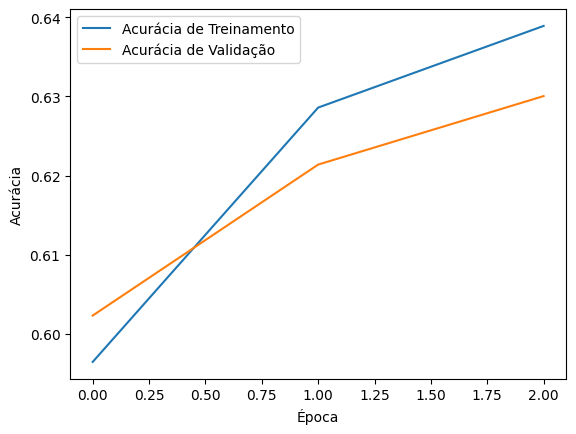

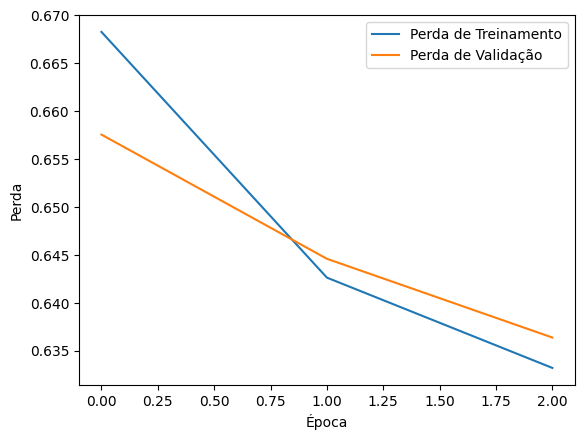

In [4]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy

# Função para carregar os dados
def carregar_dados():
    """
    Carrega dados de imagens do conjunto de dados Cats vs Dogs.
    :return: gerador de dados de treino e validação.
    """
    (dados_treino, dados_validacao), dados_info = tfds.load(
        'cats_vs_dogs',
        split=['train[:80%]', 'train[20%:]'],
        with_info=True,
        as_supervised=True,
    )
    return dados_treino, dados_validacao

# Função para preprocessamento das imagens
def preprocessar_dados(image, label):
    """
    Preprocessa imagens e rótulos.
    :param image: Imagem bruta.
    :param label: Rótulo da imagem.
    :return: Imagem preprocessada e rótulo.
    """
    image = tf.image.resize(image, (224, 224))
    image = image / 255.0
    label = tf.one_hot(label, 2)
    return image, label

# Função para criar e compilar o modelo
def criar_modelo(num_classes):
    """
    Cria o modelo de Transfer Learning utilizando a rede ResNet50.
    :param num_classes: int - Número de classes.
    :return: modelo - Modelo compilado.
    """
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    previsoes = Dense(num_classes, activation='softmax')(x)
    modelo = Model(inputs=base_model.input, outputs=previsoes)

    # Congelar as camadas da base_model
    for camada in base_model.layers:
        camada.trainable = False

    # Definir a função de perda com base no número de classes
    if num_classes == 2:
        loss = BinaryCrossentropy()
    else:
        loss = CategoricalCrossentropy()

    modelo.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])
    return modelo

# Função principal para rodar o módulo
def main():
    """
    Função principal para rodar o módulo de Transfer Learning.
    """
    # Carregar dados de treino e validação
    dados_treino, dados_validacao = carregar_dados()

    # Preprocessar os dados
    dados_treino = dados_treino.map(preprocessar_dados, num_parallel_calls=tf.data.AUTOTUNE)
    dados_validacao = dados_validacao.map(preprocessar_dados, num_parallel_calls=tf.data.AUTOTUNE)

    # Agrupar os dados em batches
    dados_treino = dados_treino.batch(32).prefetch(tf.data.AUTOTUNE)
    dados_validacao = dados_validacao.batch(32).prefetch(tf.data.AUTOTUNE)

    # Obter o número de classes
    num_classes = 2

    # Criar e compilar o modelo
    modelo = criar_modelo(num_classes)

    # Treinar o modelo
    historico = modelo.fit(dados_treino, validation_data=dados_validacao, epochs=3)

    # Exibir gráficos de precisão e perda
    plt.plot(historico.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(historico.history['val_accuracy'], label='Acurácia de Validação')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.show()

    plt.plot(historico.history['loss'], label='Perda de Treinamento')
    plt.plot(historico.history['val_loss'], label='Perda de Validação')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()

# Executar a função principal
if __name__ == "__main__":
    main()
